In [131]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import os
import numpy as np
import pandas as pd
from joblib import dump, load
from time import time
from sklearn.feature_selection import RFECV
from sklearn.metrics import roc_auc_score
from joblib import dump, load

## LOAD FILES

In [18]:
#LOAD MODEL

RFC_path='RFC_FullData.joblib'
RFC = load(RFC_path) 

In [19]:
#LOAD DATA
dataDir = 'CleanDataFinal'

#LOAD TRAINING DATA
#features
path = os.path.join(dataDir, 'trainFeaturesFinal.csv')
train_x_pd = pd.read_csv (path, index_col = 'HHX')
train_x = train_x_pd.to_numpy()
print(train_x.shape)

#target
path = os.path.join(dataDir, 'trainTargetFinal.csv')
train_y_pd = pd.read_csv (path, index_col = 'HHX')
train_y = train_y_pd.to_numpy().flatten()
print(train_y.shape)

#LOAD TESTING DATA
#features
path = os.path.join(dataDir, 'testFeaturesFinal.csv')
test_x_pd = pd.read_csv (path, index_col = 'HHX')
test_x = test_x_pd.to_numpy()
print(test_x.shape)

#target
path = os.path.join(dataDir, 'testTargetFinal.csv')
test_y_pd = pd.read_csv (path, index_col = 'HHX')
test_y = test_y_pd.to_numpy().flatten()
print(test_y.shape)

(22222, 5290)
(22222,)
(5556, 5290)
(5556,)


## FEATURE IMPORTANCE USING PERMUTATION IMPORTANCE ALGORITHM

In [45]:
#adapted from https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

start_time = time()
result = permutation_importance(
    RFC, test_x, test_y, n_repeats=10, random_state=42, n_jobs=2, scoring='roc_auc_ovr_weighted')
elapsed_time = time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 40230.287 seconds


In [46]:
forest_importances = pd.Series(result.importances_mean, index=test_x_pd.columns)
forest_std = pd.Series(result.importances_std, index=test_x_pd.columns)

#save data
path = 'FeatureImportanceFullData.csv'
forest_importances.to_csv(path)
path = 'FeatureImportanceSTDFullData.csv'
forest_importances.to_csv(path)


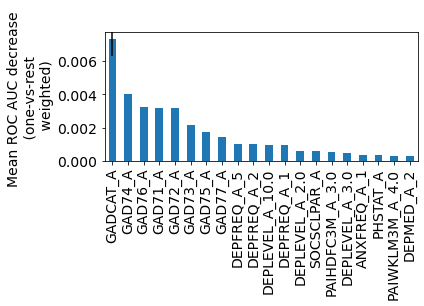

In [49]:
#plot top feature importance

#sort data
forest_importances = forest_importances.sort_values(ascending=False)
#grab top few features
num_features = 20
top_features = forest_importances.iloc[:num_features]
top_features_STD = forest_std.iloc[:num_features]

#plot top features
fig, ax = plt.subplots(figsize=(6, 4))
top_features.plot.bar(yerr=top_features_STD, ax=ax, fontsize=14)
ax.set_ylabel("Mean ROC AUC decrease \n (one-vs-rest \n weighted)", fontsize=14)
fig.tight_layout()

#save figure
path='FullData_FeatureImportance.png'
plt.savefig(path, bbox_inches="tight")

plt.show()



## FEATURE SELECTION USING RECURSIVE FEATURE SELECTION

In [62]:
#RUN FEATURE SELECTION ON FULL DATASET
#Adapted from https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html#sphx-glr-auto-examples-feature-selection-plot-rfe-with-cross-validation-py

# Create the RFE object and compute a cross-validated score.
## Wasn't seeing huge changes in scores for the different models
# used high number of trees, lowish number of features
start_time = time()

n_estimators=460
max_features=50
RFC = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features)

min_features_to_select = 50  # Minimum number of features to consider
step=25
rfecv = RFECV(
    estimator=RFC,
    step=step,
    scoring="roc_auc_ovr_weighted",
    min_features_to_select=min_features_to_select)

rfecv.fit(train_x, train_y)

print("Optimal number of features : %d" % rfecv.n_features_)
elapsed_time = time() - start_time
print(f"Elapsed time to select features: {elapsed_time:.3f} seconds")

Optimal number of features : 415
Elapsed time to select features: 69263.773 seconds


In [63]:
#SAVE DATA 
resPD = pd.DataFrame(rfecv.cv_results_)

features_max = train_x.shape[1]
features_min = features_max-(len(resPD)-1)*step
features_used = np.linspace(features_max, features_min, len(resPD))
resPD['features_used'] = features_used

dataDir = 'FeatureSelection'

if not os.path.exists(dataDir):
    os.makedirs(dataDir)

dataFile = 'FeatureSelection_cv_results.csv'
path = os.path.join(dataDir, dataFile)

resPD.to_csv(path)

selected_features = pd.DataFrame(rfecv.ranking_, columns=['Ranking'])
selected_features['FeatureName'] = train_x_pd.columns.to_list()

dataFile = 'FeatureSelection_SelectedFeatures.csv'
path = os.path.join(dataDir, dataFile)

selected_features.to_csv(path)

In [78]:
#LOAD DATA 

dataDir = 'AnalysisData'
dataSubDir= 'FeatureSelection'

dataFile = 'FeatureSelection_cv_results.csv'
path = os.path.join(dataDir, dataSubDir, dataFile)
resPD = pd.read_csv(path, index_col=0)

dataFile = 'FeatureSelection_SelectedFeatures.csv'
path = os.path.join(dataDir, dataSubDir, dataFile)
selected_features = pd.read_csv(path, index_col=0)

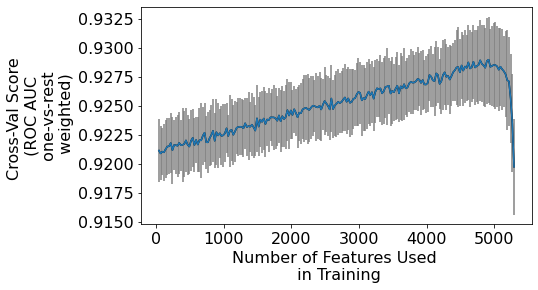

In [79]:
#GRAPH CV SCORE VS NUMBER OF FEATURES

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(7,4))
plt.errorbar(resPD.features_used, resPD.mean_test_score, yerr=resPD.std_test_score, ecolor='gray')
plt.plot(resPD.features_used, resPD.mean_test_score, color='k')
plt.xlabel("Number of Features Used \n in Training", fontsize=16)
plt.ylabel("Cross-Val Score \n (ROC AUC \n one-vs-rest \n weighted)", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

#save figure
path='FeatureSelection.png'
plt.savefig(path, bbox_inches="tight")

plt.show()

## TRAIN REDUCED FEATURE MODELS

In [90]:
#CHOOSE THREE SUBSETS OF FEATURES
#lowest rank for subsets = 196
features_max_rank = selected_features.Ranking.max()
#will use rank =1, 50, 100

#make lists of features for each rank 
features_01 = selected_features.FeatureName[selected_features.Ranking == 1].tolist()
print ('rank 01 number of features: ', len(features_01))
features_50 = selected_features.FeatureName[selected_features.Ranking <= 50].tolist()
print ('rank <=50 number of features: ', len(features_50))
features_100 = selected_features.FeatureName[selected_features.Ranking <= 100].tolist()
print ('rank <=100 number of features: ', len(features_100))

rank 01 number of features:  415
rank <=50 number of features:  1640
rank <=100 number of features:  2890


In [116]:
#CROSS-VAL ON REDUCED-FEATURES MODEL
t0 = time()

cv_scores = []
feature_lists = [features_01, features_50, features_100]

#model parameters
n_estimators=460
max_features=50

for fl in feature_lists:
    #create RFC object
    RFC = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features, random_state=42)
    #select features
    train_x_subset = train_x_pd.loc[:, fl].to_numpy()
    scores = cross_val_score(RFC, train_x_subset, train_y, cv=10, scoring='roc_auc_ovr_weighted')
    cv_scores.append(scores)

print("done in %0.3fs" % (time() - t0))

done in 3375.995s


In [127]:
#SAVE DATA
#make df
cv_scores_copy = cv_scores
idx = [str(len(features_01))+'_FEATURES', str(len(features_50))+'_FEATURES', str(len(features_100))+'_FEATURES']
col = []
for i in np.arange(1, 11):
    c = 'SPLIT_'+str(i)
    col.append(c)

scores_pd = pd.DataFrame (cv_scores_copy, index=idx, columns = col)
cv_scores_pd = scores_pd.copy()
cv_scores_pd['MEAN'] = scores_pd.mean(axis=1)
cv_scores_pd['STD'] = scores_pd.std(axis=1)

#make directory 
dataDir = 'ReducedFeatures'
if not os.path.exists(dataDir):
    os.mkdir(dataDir)

#store imputed testing data
filepath = os.path.join(dataDir, 'CrossVal.csv')
cv_scores_pd.to_csv(filepath) 

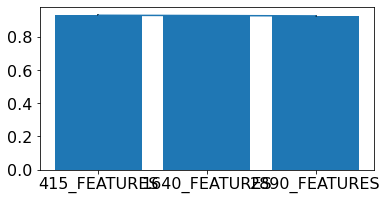

In [129]:
#PLOT CV 
plt.figure(figsize = (6, 3))
x = np.arange(3)
plt.bar(x, cv_scores_pd.MEAN)
plt.errorbar(x, cv_scores_pd.MEAN, yerr=cv_scores_pd.STD, ecolor='k')
plt.xticks(x, cv_scores_pd.index.to_list(), fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [133]:
#MAKE FINAL MODELS
t0 = time()

test_scores = []
trained_models = []
feature_lists = [features_01, features_50, features_100]

#for saving results
dataDir = 'ReducedFeatures'
if not os.path.exists(dataDir):
    os.mkdir(dataDir)
    
trained_model_paths = []
for fl in feature_lists:
    datafile = 'RFC_' + str(len(fl)) + '_features.joblib'
    path = os.path.join(dataDir, datafile)
    trained_model_paths.append(path)
    
#model parameters
n_estimators=460
max_features=50

for fl, path in zip(feature_lists, trained_model_paths):
    i = 1
    #create RFC object
    RFC = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features, random_state=42)
    #select features
    train_x_subset = train_x_pd.loc[:, fl].to_numpy()
    #train model
    RFC.fit(train_x_subset, train_y)
    #save model and put in list
    dump(RFC, path)
    trained_models.append(RFC)
    #test model on subset of features
    test_x_subset = test_x_pd.loc[:, fl].to_numpy()
    roc_auc_test = roc_auc_score(test_y, RFC.predict_proba(test_x_subset), multi_class='ovr', average='weighted')
    test_scores.append(roc_auc_test)
    #give update
    print('done with model: ' + str(i))
    i = i+1
    
#save scores
idx = [str(len(features_01))+'_FEATURES', str(len(features_50))+'_FEATURES', str(len(features_100))+'_FEATURES']
test_scores_pd = pd.DataFrame(test_scores, index=idx, columns=['ROC_AUC_OVR_WEIGHTED'])
filepath = 'TestScores.csv'
path = os.path.join(dataDir, filepath)
test_scores_pd.to_csv(path)

print("done in %0.3fs" % (time() - t0))

done with model: 1
done with model: 1
done with model: 1
done in 292.752s


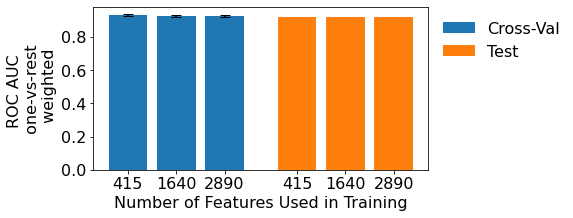

In [156]:
#GRAPH ALL SCORES TOGETHER

x_cv = np.arange(3)
x_delta = 0.5
x_test_start = len(x_cv)+x_delta
x_test = np.arange (x_test_start, x_test_start+3)
x=np.concatenate((x_cv, x_test))

plt.figure(figsize=(6,3))
#plot cv scores
plt.bar(x_cv, cv_scores_pd.MEAN, label = 'Cross-Val', yerr=cv_scores_pd.STD, capsize=5)

#plot test scores
plt.bar(x_test, test_scores_pd.to_numpy().flatten(), label = 'Test')

#formatting
x_labels = [str(len(features_01)), str(len(features_50)), str(len(features_100))]*2
plt.xticks(x, x_labels, fontsize=16)
plt.xlabel ('Number of Features Used in Training', fontsize=16)

plt.yticks(fontsize=16)
plt.ylabel('ROC AUC \n one-vs-rest \n weighted', fontsize=16)

plt.legend(bbox_to_anchor=(1, 1), frameon=False, fontsize=16)

#save figure
dataDir = 'ReducedFeatures'
datafile = 'ReducedFeaturesScoring'
path = os.path.join(dataDir, datafile)
plt.savefig(path, bbox_inches="tight")
    
plt.show()